# Домашняя работа 2
 Изучение GCN, GraphSAGE, GAT, GIN — на задачах "node classification" и "link prediction"




В этой домашней работе вам предстоит:

- освоить и углубить понимание нескольких графовых нейросетевых архитектур (GCN, GraphSAGE, GAT, GIN)
-  применить их к задачам классификации узлов и предсказания рёбер
- исследовать влияние глубины, скрытой размерности, оптимизации GNN на качество обучения
- построить сравнительные эксперименты и сделать собственные выводы о преимуществах разных подходов

In [1]:
# !pip install torch-geometric tabulate -q

In [2]:
from typing import Literal, Optional

import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, SAGEConv, GATv2Conv, GINConv, PairNorm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.transforms import RandomLinkSplit

import matplotlib.pyplot as plt

from tabulate import tabulate

import warnings
warnings.filterwarnings('ignore')

from train_eval_node_classification import train_node_classification, evaluate_node_classification
from train_eval_link_prediction import train_link_prediction, evaluate_link_prediction

### Загрузка и визуализация данных

Датасет: Cora - Граф научных цитирований

In [3]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]
print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


# Часть 1. Node Classification

### 1.1 Реализация расширенного GCN

Создайте GCN-модель с:

- тремя слоями GCNConv,
- Dropout после второго слоя,
- активацией ReLU в скрытых слоях.

**Вопросы:**

- Улучшилось ли качество на Cora в сравнении с результатом, который был получен на практике?
- Как изменилась динамика сходимости?
- Наблюдается ли переобучение?

In [4]:
class GCN(torch.nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            hidden_channels=[32, 32],
            node_dropout=0.5,
            edge_dropout=0.0,
            normalization: Literal['batch', 'layer', 'pair', 'none']='none',
            conv_type: Literal['gcn', 'sage', 'gatv2', 'gin']='gcn',
            gatv2_heads: Optional[int]=None,
            use_skip_connections=False,
        ):
        super().__init__()

        self.node_dropout = node_dropout
        self.edge_dropout = edge_dropout
        self.use_skip_connections = use_skip_connections

        layer_in_channels = in_channels

        assert conv_type != 'gatv2' or gatv2_heads is not None, "For GATv2 conv_type, gatv2_heads must be specified."

        conv_factory = {
            'gcn': lambda in_, out_: GCNConv(in_, out_),
            'sage': lambda in_, out_: SAGEConv(in_, out_),
            'gatv2': lambda in_, out_: GATv2Conv(in_, out_, heads=gatv2_heads, concat=False),
            # 'gin': lambda in_, out_: GINConv(), # TODO: реализовать GINConv с MLP
        }
        self.gcn_layers = torch.nn.ModuleList()
        for hidden_channel in hidden_channels:
            if use_skip_connections and layer_in_channels != hidden_channel:
                print(f"Warning: Skip connections wouldn't be used for layer with in_channels={layer_in_channels} and out_channels={hidden_channel}")

            self.gcn_layers.append(conv_factory[conv_type](layer_in_channels, hidden_channel))
            layer_in_channels = hidden_channel
        self.gcn_layers.append(conv_factory[conv_type](layer_in_channels, out_channels))

        normalization_factory = {
            'batch': lambda ch: torch.nn.BatchNorm1d(ch),
            'layer': lambda ch: torch.nn.LayerNorm(ch),
            'pair': lambda ch: PairNorm(),
            'none': lambda ch: torch.nn.Identity(),
        }
        self.normalization_layers = torch.nn.ModuleList()
        for hidden_channel in hidden_channels:
            self.normalization_layers.append(normalization_factory[normalization](hidden_channel))

    def forward(self, x, edge_index):
        if self.node_dropout > 0:
            x = F.dropout(x, p=self.node_dropout, training=self.training)

        for conv, norm in zip(self.gcn_layers, self.normalization_layers):
            skip_x = x  # для пропуска

            x = conv(x, edge_index)
            x = F.relu(x)
            if self.node_dropout > 0:
                x = F.dropout(x, p=self.node_dropout, training=self.training)
            x = norm(x)

            if self.use_skip_connections and skip_x.size() == x.size():
                x = x + skip_x  # добавляем пропуск
                
        # т.к. нормализации на одну меньше, последний слой gcn не будет применен в цикле
        x = self.gcn_layers[-1](x, edge_index)
        return F.log_softmax(x, dim=1)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

def train_and_evaluate_node_model(model, data=data):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    _, val_acc = train_node_classification(model, data, optimizer, epochs=300)
    test_acc = evaluate_node_classification(model, data, mask=data.test_mask)
    train_acc = evaluate_node_classification(model, data, mask=data.train_mask)

    plt.figure(figsize=(8, 4))
    plt.plot(val_acc)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Валидационная точность")
    plt.grid(True)
    plt.show()

    return train_acc, val_acc[-1], test_acc

Epoch 000, Loss: 1.9393, Val Acc: 0.4760
Epoch 010, Loss: 0.5827, Val Acc: 0.7980
Epoch 020, Loss: 0.1556, Val Acc: 0.7640
Epoch 030, Loss: 0.0452, Val Acc: 0.7820
Early stopping at epoch 32


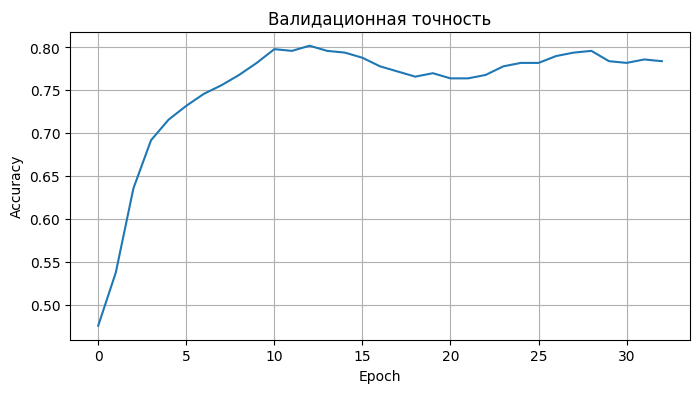

Accuracy на тестовой выборке: 0.8100


In [6]:
# Инициализация модели
model = GCN(in_channels=dataset.num_features, out_channels=dataset.num_classes).to(device)

train_acc, val_acc, test_acc = train_and_evaluate_node_model(model, data)
print(f"Accuracy на тестовой выборке: {test_acc:.4f}")

### 1.2 Исследование глубины признакового пространства

Проведите эксперимент с различными значениями скрытой размерности:

```
hidden_dim = 8, 16, 32, 64
```

Постройте таблицу:

| Hidden Dim | Train Acc | Val Acc | Test Acc |
| ---------- | --------- | ------- | -------- |

**Вопросы:**

- Сравните полученные результаты
- Влияет ли размерность на качество обучения?


==================== Hidden Size: 8 ====================
Epoch 000, Loss: 1.9529, Val Acc: 0.2500
Epoch 010, Loss: 1.5341, Val Acc: 0.5460
Epoch 020, Loss: 1.1534, Val Acc: 0.6520
Epoch 030, Loss: 0.8396, Val Acc: 0.7360
Epoch 040, Loss: 0.6763, Val Acc: 0.7360
Epoch 050, Loss: 0.6902, Val Acc: 0.7540
Epoch 060, Loss: 0.4488, Val Acc: 0.7540
Epoch 070, Loss: 0.4860, Val Acc: 0.7520
Epoch 080, Loss: 0.3878, Val Acc: 0.7500
Epoch 090, Loss: 0.3124, Val Acc: 0.7620
Early stopping at epoch 96


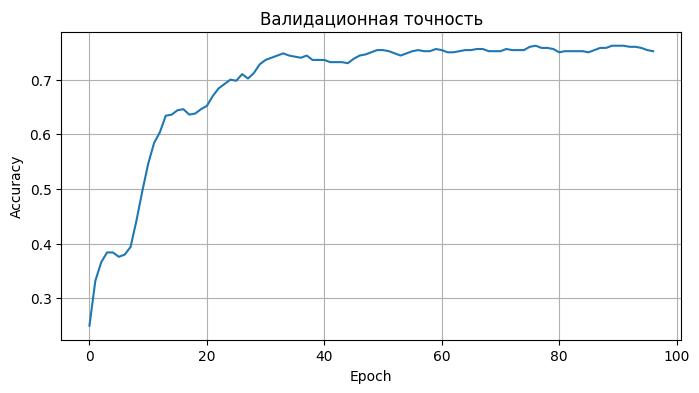

==================== Hidden Size: 16 ====================
Epoch 000, Loss: 1.9542, Val Acc: 0.4060
Epoch 010, Loss: 1.2162, Val Acc: 0.6680
Epoch 020, Loss: 0.5389, Val Acc: 0.7640
Epoch 030, Loss: 0.2418, Val Acc: 0.7600
Epoch 040, Loss: 0.2521, Val Acc: 0.7720
Early stopping at epoch 45


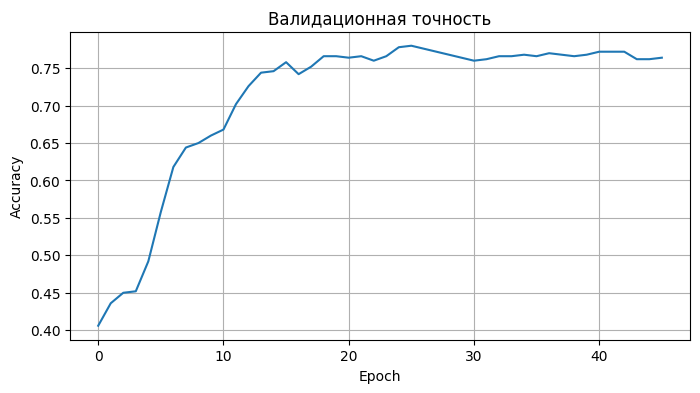

==================== Hidden Size: 32 ====================
Epoch 000, Loss: 1.9451, Val Acc: 0.2540
Epoch 010, Loss: 0.7029, Val Acc: 0.7520
Epoch 020, Loss: 0.1746, Val Acc: 0.7860
Epoch 030, Loss: 0.0731, Val Acc: 0.7680
Early stopping at epoch 33


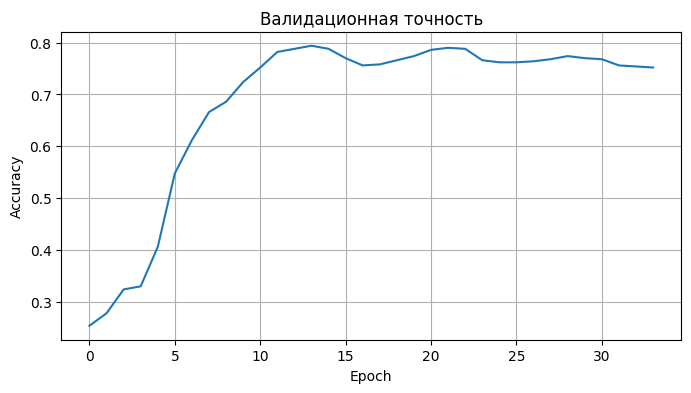

==================== Hidden Size: 64 ====================
Epoch 000, Loss: 1.9553, Val Acc: 0.6440
Epoch 010, Loss: 0.2148, Val Acc: 0.7780
Epoch 020, Loss: 0.0556, Val Acc: 0.7860
Epoch 030, Loss: 0.0302, Val Acc: 0.7780
Early stopping at epoch 34


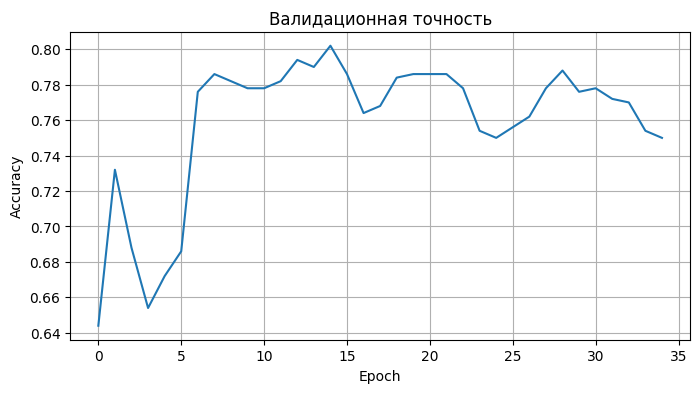

  Hidden Size    Train Acc    Val Acc    Test Acc
-------------  -----------  ---------  ----------
            8     1             0.752       0.785
           16     1             0.764       0.802
           32     0.971429      0.752       0.812
           64     0.978571      0.75        0.807


In [7]:
results = []

for hidden_size in [8, 16, 32, 64]:
    print("=" * 20 + f" Hidden Size: {hidden_size} " + "=" * 20)
    model = GCN(in_channels=dataset.num_features, out_channels=dataset.num_classes, hidden_channels=[hidden_size, hidden_size]).to(device)
    train_acc, val_acc, test_acc = train_and_evaluate_node_model(model, data)
    results.append([hidden_size, train_acc, val_acc, test_acc])
    
print(tabulate(results, headers=["Hidden Size", "Train Acc", "Val Acc", "Test Acc"]))

### 1.3 Исследование нормализаций

Добавьте BatchNorm / LayerNorm / PairNorm (можно комбинировать) между слоями GCN и сравните:

- скорость сходимости,
- валидационную точность,
- чувствительность к learning rate.

**Вопросы:**
- Оцените каждый вариант:
    - Улучшилась ли стабильность обучения?
    - Снизился ли эффект over-smoothing?
- Какой вариант нормализации показал себя лучше всего для данной задачи?



==================== Normalization: batch ====================
Epoch 000, Loss: 2.2079, Val Acc: 0.2680
Epoch 010, Loss: 0.3703, Val Acc: 0.7620
Epoch 020, Loss: 0.1359, Val Acc: 0.7400
Epoch 030, Loss: 0.0480, Val Acc: 0.7040
Early stopping at epoch 31


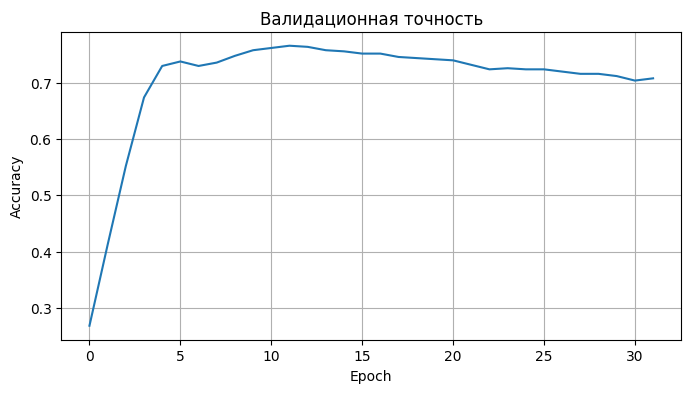

==================== Normalization: layer ====================
Epoch 000, Loss: 2.2107, Val Acc: 0.3800
Epoch 010, Loss: 0.5579, Val Acc: 0.7460
Epoch 020, Loss: 0.1908, Val Acc: 0.7360
Early stopping at epoch 27


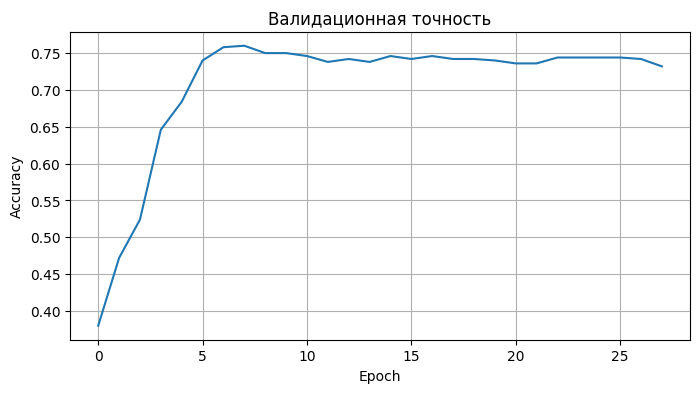

==================== Normalization: pair ====================
Epoch 000, Loss: 1.9680, Val Acc: 0.4660
Epoch 010, Loss: 1.2508, Val Acc: 0.7480
Epoch 020, Loss: 0.8789, Val Acc: 0.7040
Early stopping at epoch 29


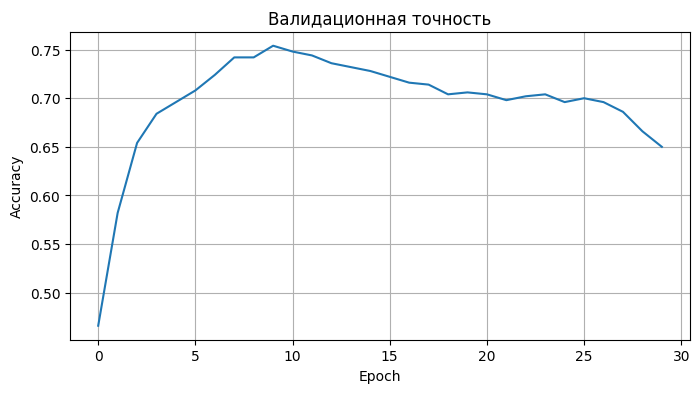

Normalization      Train Acc    Val Acc    Test Acc
---------------  -----------  ---------  ----------
batch               0.957143      0.708       0.78
layer               0.978571      0.732       0.774
pair                0.964286      0.65        0.759


In [8]:
results = []

for normalization in ['batch', 'layer', 'pair']:
    print("=" * 20 + f" Normalization: {normalization} " + "=" * 20)
    model = GCN(in_channels=dataset.num_features, out_channels=dataset.num_classes, normalization=normalization).to(device)
    train_acc, val_acc, test_acc = train_and_evaluate_node_model(model, data)
    results.append([normalization, train_acc, val_acc, test_acc])

print(tabulate(results, headers=["Normalization", "Train Acc", "Val Acc", "Test Acc"]))

### 1.4 Residual Connections (Skip Connections)

Добавление остаточных связей:

$
h_v^{(k+1)} = h_v^{(k)} + \text{GCNLayer}(h_v^{(k)})
$

— улучшает распространение градиентов и сохраняет индивидуальность узлов.

Задание:
1. Добавьте residual connection между слоями GCN.
2. Проверьте, можно ли теперь использовать более глубокую модель (3–4 слоя)

**Вопросы:**

* Улучшается ли обучение GCN?
* Перестаёт ли сеть «слишком усреднять» узлы?



==================== Depth: 2 ====================
Epoch 000, Loss: 1.9621, Val Acc: 0.4660
Epoch 010, Loss: 0.5017, Val Acc: 0.7800
Epoch 020, Loss: 0.1554, Val Acc: 0.7900
Epoch 030, Loss: 0.0404, Val Acc: 0.7860
Early stopping at epoch 36


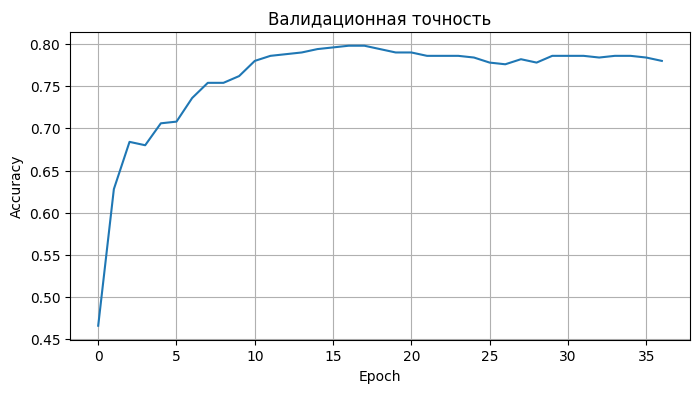

==================== Depth: 3 ====================
Epoch 000, Loss: 1.9593, Val Acc: 0.3500
Epoch 010, Loss: 0.4137, Val Acc: 0.7500
Epoch 020, Loss: 0.0706, Val Acc: 0.7600
Epoch 030, Loss: 0.0237, Val Acc: 0.7740
Early stopping at epoch 35


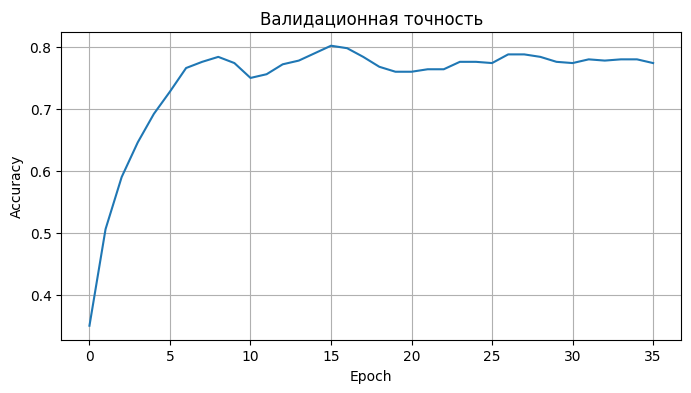

==================== Depth: 4 ====================
Epoch 000, Loss: 1.9671, Val Acc: 0.2180
Epoch 010, Loss: 0.3789, Val Acc: 0.7680
Epoch 020, Loss: 0.0971, Val Acc: 0.7980
Epoch 030, Loss: 0.0388, Val Acc: 0.7740
Early stopping at epoch 32


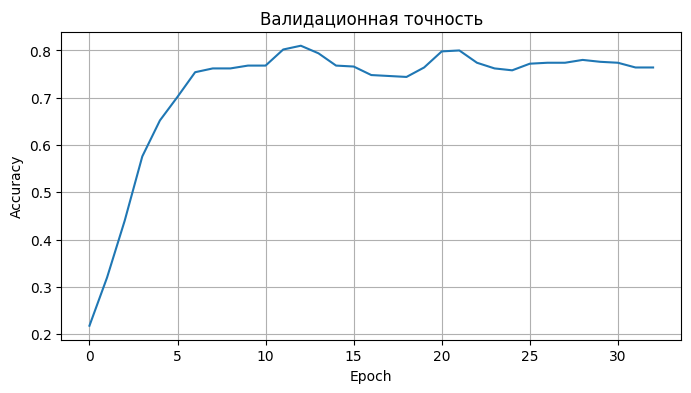

  Depth with Skip Connections    Train Acc    Val Acc    Test Acc
-----------------------------  -----------  ---------  ----------
                            2     1             0.78        0.821
                            3     1             0.774       0.812
                            4     0.978571      0.764       0.818


In [9]:
results = []

for depth in [2, 3, 4]:
    print("=" * 20 + f" Depth: {depth} " + "=" * 20)
    hidden_channels = [32] * (depth - 1)
    model = GCN(in_channels=dataset.num_features, out_channels=dataset.num_classes, hidden_channels=hidden_channels, use_skip_connections=True).to(device)
    train_acc, val_acc, test_acc = train_and_evaluate_node_model(model, data)
    results.append([depth, train_acc, val_acc, test_acc])

print(tabulate(results, headers=["Depth with Skip Connections", "Train Acc", "Val Acc", "Test Acc"]))

### 1.5 DropEdge

DropEdge случайно удаляет часть рёбер:

$
\tilde{E} = \text{Dropout}(E)
$

Этот метод:
- уменьшает степень узлов,
- снижает oversmoothing,
- действует как регуляризация.

Задание:
1. Реализуйте DropEdge: случайно удаляйте `p` рёбер на каждой эпохе.
2. Обучите GCN на этом изменённом графе.
3. Постройте метрики качества.

**Вопросы:**
- Улучшается ли устойчивость сети к переобучению?
- Какой процент удаляемых рёбер оптимален?

Epoch 000, Loss: 1.9440, Val Acc: 0.2920
Epoch 010, Loss: 0.6859, Val Acc: 0.7820
Epoch 020, Loss: 0.1518, Val Acc: 0.7760
Epoch 030, Loss: 0.0735, Val Acc: 0.7660
Early stopping at epoch 32


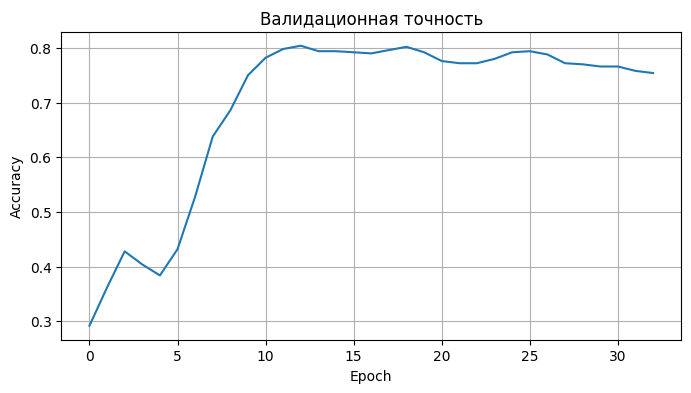

Accuracy на тестовой выборке с DropEdge: 0.8070


In [10]:
model = GCN(in_channels=dataset.num_features, out_channels=dataset.num_classes, edge_dropout=0.5).to(device)
train_acc, val_acc, test_acc = train_and_evaluate_node_model(model, data)
print(f"Accuracy на тестовой выборке с DropEdge: {test_acc:.4f}")

### 1.6 Исследование различных архитектур
Выберите 2 базовые архитектуры из списка: GraphSAGE, GAT(v2), GIN. Реализуйте их для задачи node classification и сравните полученные результаты.

Комментарий: при реализации, можно использовать наработки с предыдущих пунктов - добавлять разные виды модификаций (увеличивать число слоев / добавлять слои нормализации / residual conections...)

==================== Architecture: gcn ====================
Epoch 000, Loss: 1.9466, Val Acc: 0.3720
Epoch 010, Loss: 0.6415, Val Acc: 0.7820
Epoch 020, Loss: 0.1201, Val Acc: 0.7740
Epoch 030, Loss: 0.0412, Val Acc: 0.7520
Early stopping at epoch 32


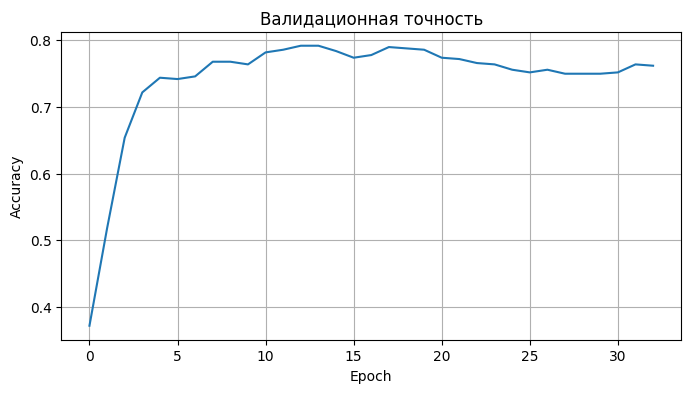

==================== Architecture: sage ====================
Epoch 000, Loss: 1.9399, Val Acc: 0.3160
Epoch 010, Loss: 0.6340, Val Acc: 0.7620
Epoch 020, Loss: 0.0718, Val Acc: 0.8040
Epoch 030, Loss: 0.0706, Val Acc: 0.7820
Early stopping at epoch 39


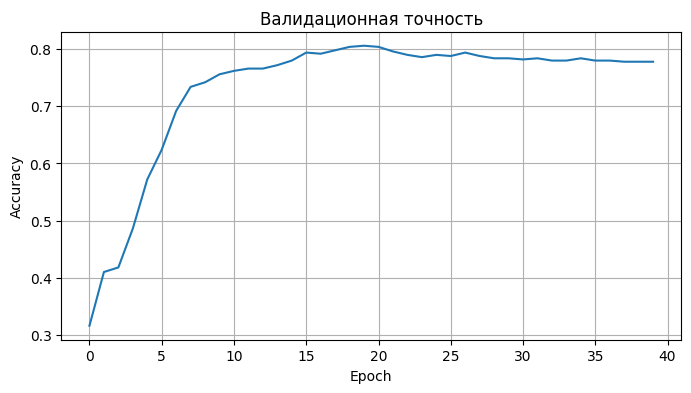

==================== Architecture: gatv2 ====================
Epoch 000, Loss: 1.9472, Val Acc: 0.1220
Epoch 010, Loss: 1.3922, Val Acc: 0.5920
Epoch 020, Loss: 0.3485, Val Acc: 0.7300
Epoch 030, Loss: 0.2063, Val Acc: 0.7620
Epoch 040, Loss: 0.1390, Val Acc: 0.7380
Early stopping at epoch 49


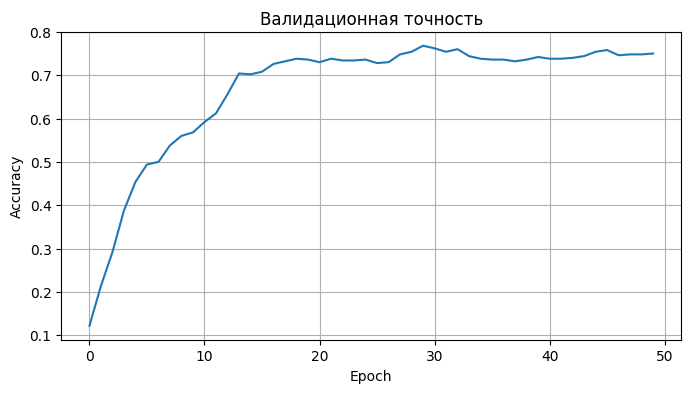

Architecture      Train Acc    Val Acc    Test Acc
--------------  -----------  ---------  ----------
gcn                0.992857      0.762       0.799
sage               1             0.778       0.808
gatv2              0.992857      0.75        0.788


In [11]:
results = []

for architecture in ['gcn', 'sage', 'gatv2']:
    print("=" * 20 + f" Architecture: {architecture} " + "=" * 20)
    model = GCN(in_channels=dataset.num_features, out_channels=dataset.num_classes, conv_type=architecture, gatv2_heads=4).to(device)
    train_acc, val_acc, test_acc = train_and_evaluate_node_model(model, data)
    results.append([architecture, train_acc, val_acc, test_acc])

print(tabulate(results, headers=["Architecture", "Train Acc", "Val Acc", "Test Acc"]))

# Часть 2. Link Prediction

### 2.1 Реализация MLP-декодера

Вместо dot-product декодера:

$
s_{uv} = z_u^\top z_v
$

реализуйте:

$
s_{uv} = \mathrm{MLP}([z_u ,||, z_v])
$

Сравните качество (AUC, AP) с dot-product.

In [12]:
# Применим RandomLinkSplit
transform = RandomLinkSplit(
    is_undirected=True,              # Граф без направлений
    split_labels=True,               # Метки (0/1) будут созданы
    add_negative_train_samples=True  # Добавить отрицательные примеры в train
)

train_data, val_data, test_data = transform(data)
train_data, val_data = train_data.to(device), val_data.to(device)

def train_and_evaluate_link_model(model, decoder, train_data=train_data, val_data=val_data, test_data=test_data):
    all_parameters = list(model.parameters()) + list(decoder.parameters())
    optimizer = torch.optim.Adam(all_parameters, lr=0.01, weight_decay=5e-4)

    train_losses, val_losses, val_acc = train_link_prediction(model, decoder, train_data, val_data, optimizer, epochs=200)
    # Оценка на тесте
    test_acc, test_ap = evaluate_link_prediction(model, decoder, test_data)

    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel("Epoch")
    plt.title("Loss during Link Prediction Training")
    plt.legend()
    plt.grid(True)
    plt.show()

    return val_acc[-1], test_acc, test_ap

In [13]:
# Определим GCN Encoder
class GCNEncoder(torch.nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            dropout=0.5,
            conv_type: Literal['gcn', 'sage', 'gatv2', 'gin']='gcn',
            gatv2_heads: Optional[int]=None,
        ):
        super().__init__()

        assert conv_type != 'gatv2' or gatv2_heads is not None, "For GATv2 conv_type, gatv2_heads must be specified."

        conv_factory = {
            'gcn': lambda in_, out_: GCNConv(in_, out_),
            'sage': lambda in_, out_: SAGEConv(in_, out_),
            'gatv2': lambda in_, out_: GATv2Conv(in_, out_, heads=gatv2_heads, concat=False),
            # 'gin': lambda in_, out_: GINConv(), # TODO: реализовать GINConv с MLP
        }

        self.conv1 = conv_factory[conv_type](in_channels, 2 * out_channels)
        self.conv2 = conv_factory[conv_type](2 * out_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [14]:
class DotProductDecoder(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()

    def forward(self, z, pos_edge_index, neg_edge_index):
        pos_score = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
        neg_score = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)
        scores = torch.cat([pos_score, neg_score], dim=0)

        labels = torch.cat([
            torch.ones(pos_score.size(0)),
            torch.zeros(neg_score.size(0))
        ]).to(scores.device)

        return labels, scores
    
class MLPDecoder(torch.nn.Module):
    def __init__(
            self,
            in_channels,
            hidden_channels=[32, 16],
            normalization: Literal['batch', 'layer', 'none', 'pair']='none',
            dropout=0.0,
            use_skip_connections=False,
        ):
        super().__init__()

        self.dropout = dropout
        self.use_skip_connections = use_skip_connections
        
        self.feedforward_layers = torch.nn.ModuleList()
        layer_in_channels = 2 * in_channels  # конкатенация эмбеддингов двух узлов
        for hidden_channel in hidden_channels:
            if use_skip_connections and layer_in_channels != hidden_channel:
                print(f"Warning: Skip connections wouldn't be used for layer with in_channels={layer_in_channels} and out_channels={hidden_channel}")

            self.feedforward_layers.append(torch.nn.Linear(layer_in_channels, hidden_channel))
            layer_in_channels = hidden_channel
        self.feedforward_layers.append(torch.nn.Linear(layer_in_channels, 1))

        normalization_factory = {
            'batch': lambda ch: torch.nn.BatchNorm1d(ch),
            'layer': lambda ch: torch.nn.LayerNorm(ch),
            'pair': lambda ch: PairNorm(),
            'none': lambda ch: torch.nn.Identity(),
        }
        self.normalization_layers = torch.nn.ModuleList()
        for hidden_channel in hidden_channels:
            self.normalization_layers.append(normalization_factory[normalization](hidden_channel))

    def forward(self, z, pos_edge_index, neg_edge_index):
        def decode(edge_index):
            src, dst = edge_index
            edge_features = torch.cat([z[src], z[dst]], dim=1)
            
            x = edge_features
            
            for i, layer in enumerate(self.feedforward_layers[:-1]):
                skip_x = x  # для пропуска

                x = F.relu(layer(x))
                x = self.normalization_layers[i](x)
                x = F.dropout(x, p=self.dropout, training=self.training)
                
                if self.use_skip_connections and skip_x.size() == x.size():
                    x = x + skip_x
            
            x = self.feedforward_layers[-1](x).squeeze()
            
            return x

        pos_score = decode(pos_edge_index)
        neg_score = decode(neg_edge_index)
        scores = torch.cat([pos_score, neg_score], dim=0)

        labels = torch.cat([
            torch.ones(pos_score.size(0)),
            torch.zeros(neg_score.size(0))
        ]).to(scores.device)

        return labels, scores

==================== Decoder: DotProductDecoder ====================
Epoch 000, Train Loss: 0.6700, Val Loss: 1.1240, Val AUC: 0.6727
Epoch 001, Train Loss: 0.9150, Val Loss: 0.7148, Val AUC: 0.7294
Epoch 002, Train Loss: 0.6345, Val Loss: 0.9795, Val AUC: 0.6533
Epoch 003, Train Loss: 0.7495, Val Loss: 0.8392, Val AUC: 0.6735
Epoch 004, Train Loss: 0.6809, Val Loss: 0.7590, Val AUC: 0.7042
Epoch 005, Train Loss: 0.6529, Val Loss: 0.7282, Val AUC: 0.7212
Epoch 006, Train Loss: 0.6450, Val Loss: 0.7120, Val AUC: 0.7334
Epoch 007, Train Loss: 0.6369, Val Loss: 0.7005, Val AUC: 0.7485
Epoch 008, Train Loss: 0.6328, Val Loss: 0.6876, Val AUC: 0.7683
Epoch 009, Train Loss: 0.6208, Val Loss: 0.6753, Val AUC: 0.7859
Epoch 010, Train Loss: 0.6042, Val Loss: 0.6615, Val AUC: 0.7982
Epoch 011, Train Loss: 0.5912, Val Loss: 0.6428, Val AUC: 0.8069
Epoch 012, Train Loss: 0.5735, Val Loss: 0.6222, Val AUC: 0.8116
Epoch 013, Train Loss: 0.5578, Val Loss: 0.6021, Val AUC: 0.8156
Epoch 014, Train Loss

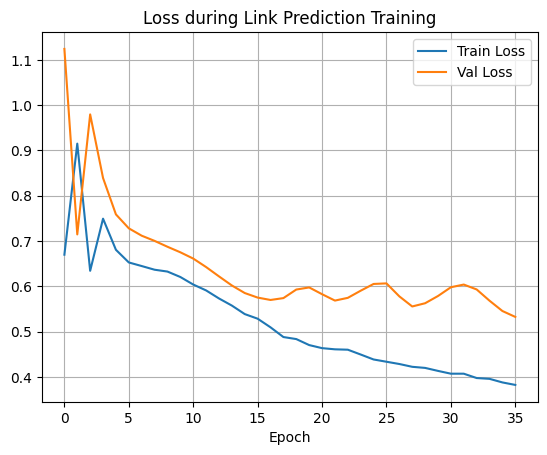

==================== Decoder: MLPDecoder ====================
Epoch 000, Train Loss: 0.6965, Val Loss: 0.7427, Val AUC: 0.6202
Epoch 001, Train Loss: 0.6937, Val Loss: 1.1261, Val AUC: 0.6358
Epoch 002, Train Loss: 0.6881, Val Loss: 2.6852, Val AUC: 0.6350
Epoch 003, Train Loss: 0.6823, Val Loss: 4.6688, Val AUC: 0.6350
Epoch 004, Train Loss: 0.6868, Val Loss: 3.1306, Val AUC: 0.6358
Epoch 005, Train Loss: 0.6787, Val Loss: 2.0128, Val AUC: 0.6346
Epoch 006, Train Loss: 0.6784, Val Loss: 1.5809, Val AUC: 0.6337
Epoch 007, Train Loss: 0.6787, Val Loss: 1.5751, Val AUC: 0.6330
Epoch 008, Train Loss: 0.6762, Val Loss: 1.9201, Val AUC: 0.6330
Epoch 009, Train Loss: 0.6704, Val Loss: 2.6885, Val AUC: 0.6341
Epoch 010, Train Loss: 0.6656, Val Loss: 3.2331, Val AUC: 0.6347
Epoch 011, Train Loss: 0.6628, Val Loss: 2.3191, Val AUC: 0.6346
Early stopping at epoch 11 (best AUC = 0.6358)
Loading the best model weights...


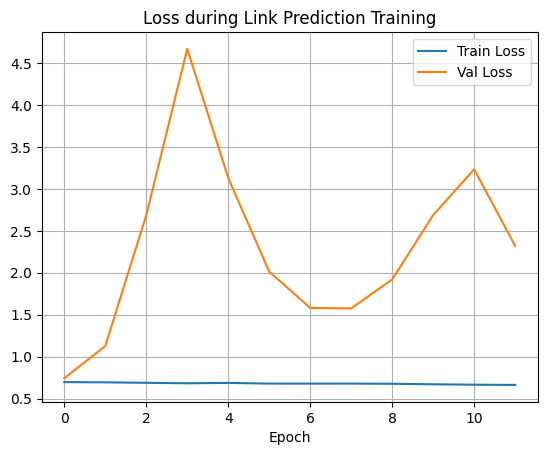

Decoder              Val Acc    Test Acc    Test AP
-----------------  ---------  ----------  ---------
DotProductDecoder   0.842624    0.871161   0.874075
MLPDecoder          0.634647    0.649485   0.697434


In [15]:
results = []

for decoder_class in [DotProductDecoder, MLPDecoder]:
    print("=" * 20 + f" Decoder: {decoder_class.__name__} " + "=" * 20)
    encoder = GCNEncoder(in_channels=dataset.num_features, out_channels=32).to(device)
    decoder = decoder_class(in_channels=32).to(device)
    val_acc, test_acc, test_ap = train_and_evaluate_link_model(encoder, decoder, train_data, val_data, test_data)
    results.append([decoder_class.__name__, val_acc, test_acc, test_ap])
    
print(tabulate(results, headers=["Decoder", "Val Acc", "Test Acc", "Test AP"]))

### 2.2 Эксперимент с negative sampling ratio

Попробуйте соотношения:

```
1:1, 1:2, 1:5, 1:10
```

Постройте таблицу для AUC и AP. Опишите полученные результаты


==================== Negative Sampling Ratio: 1.0 ====================
Epoch 000, Train Loss: 0.6936, Val Loss: 0.6939, Val AUC: 0.6584
Epoch 001, Train Loss: 0.6915, Val Loss: 0.8577, Val AUC: 0.6702
Epoch 002, Train Loss: 0.6891, Val Loss: 1.3086, Val AUC: 0.6623
Epoch 003, Train Loss: 0.6848, Val Loss: 1.9048, Val AUC: 0.6561
Epoch 004, Train Loss: 0.6797, Val Loss: 2.1959, Val AUC: 0.6456
Epoch 005, Train Loss: 0.6740, Val Loss: 2.3681, Val AUC: 0.6304
Epoch 006, Train Loss: 0.6657, Val Loss: 2.6814, Val AUC: 0.6237
Epoch 007, Train Loss: 0.6559, Val Loss: 2.0974, Val AUC: 0.6039
Epoch 008, Train Loss: 0.6567, Val Loss: 2.6760, Val AUC: 0.6218
Epoch 009, Train Loss: 0.6450, Val Loss: 2.1286, Val AUC: 0.6176
Epoch 010, Train Loss: 0.6284, Val Loss: 1.6067, Val AUC: 0.6126
Epoch 011, Train Loss: 0.6312, Val Loss: 1.7366, Val AUC: 0.6193
Early stopping at epoch 11 (best AUC = 0.6702)
Loading the best model weights...


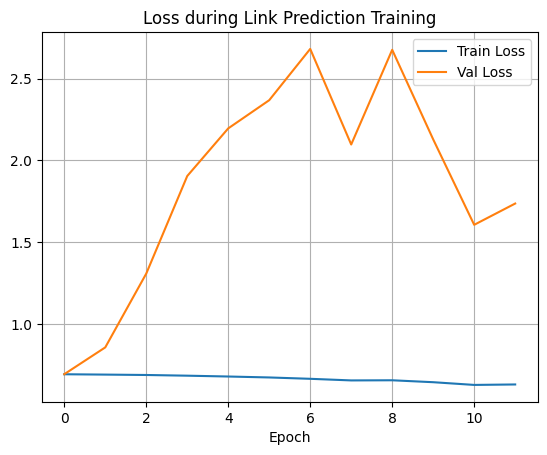

==================== Negative Sampling Ratio: 0.5 ====================
Epoch 000, Train Loss: 0.7110, Val Loss: 0.7807, Val AUC: 0.6771
Epoch 001, Train Loss: 0.6587, Val Loss: 3.2356, Val AUC: 0.6782
Epoch 002, Train Loss: 0.6074, Val Loss: 5.4280, Val AUC: 0.6809
Epoch 003, Train Loss: 0.6427, Val Loss: 3.3308, Val AUC: 0.6834
Epoch 004, Train Loss: 0.6038, Val Loss: 2.1299, Val AUC: 0.6857
Epoch 005, Train Loss: 0.6165, Val Loss: 1.7791, Val AUC: 0.6862
Epoch 006, Train Loss: 0.6234, Val Loss: 1.9080, Val AUC: 0.6873
Epoch 007, Train Loss: 0.6152, Val Loss: 2.4627, Val AUC: 0.6877
Epoch 008, Train Loss: 0.6026, Val Loss: 3.4259, Val AUC: 0.6880
Epoch 009, Train Loss: 0.5957, Val Loss: 4.4178, Val AUC: 0.6882
Epoch 010, Train Loss: 0.6023, Val Loss: 4.5114, Val AUC: 0.6878
Epoch 011, Train Loss: 0.6020, Val Loss: 3.8094, Val AUC: 0.6870
Epoch 012, Train Loss: 0.5926, Val Loss: 3.0201, Val AUC: 0.6854
Epoch 013, Train Loss: 0.5904, Val Loss: 2.5369, Val AUC: 0.6835
Epoch 014, Train Lo

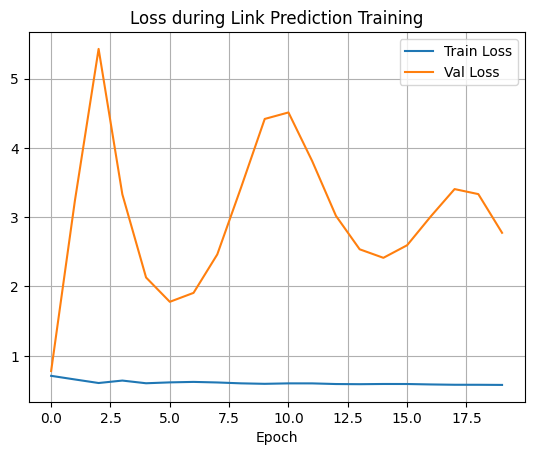

==================== Negative Sampling Ratio: 0.2 ====================
Epoch 000, Train Loss: 0.7568, Val Loss: 0.4969, Val AUC: 0.6110
Epoch 001, Train Loss: 0.7284, Val Loss: 0.7637, Val AUC: 0.6831
Epoch 002, Train Loss: 0.6655, Val Loss: 1.9168, Val AUC: 0.6844
Epoch 003, Train Loss: 0.5562, Val Loss: 4.4462, Val AUC: 0.6833
Epoch 004, Train Loss: 0.4344, Val Loss: 9.0109, Val AUC: 0.6825
Epoch 005, Train Loss: 0.4794, Val Loss: 9.6942, Val AUC: 0.6842
Epoch 006, Train Loss: 0.4996, Val Loss: 8.0052, Val AUC: 0.6862
Epoch 007, Train Loss: 0.4465, Val Loss: 5.9722, Val AUC: 0.6884
Epoch 008, Train Loss: 0.4181, Val Loss: 4.5144, Val AUC: 0.6906
Epoch 009, Train Loss: 0.4334, Val Loss: 3.7676, Val AUC: 0.6929
Epoch 010, Train Loss: 0.4485, Val Loss: 3.5542, Val AUC: 0.6948
Epoch 011, Train Loss: 0.4510, Val Loss: 3.7407, Val AUC: 0.6955
Epoch 012, Train Loss: 0.4399, Val Loss: 4.2497, Val AUC: 0.6961
Epoch 013, Train Loss: 0.4214, Val Loss: 4.9868, Val AUC: 0.6964
Epoch 014, Train Lo

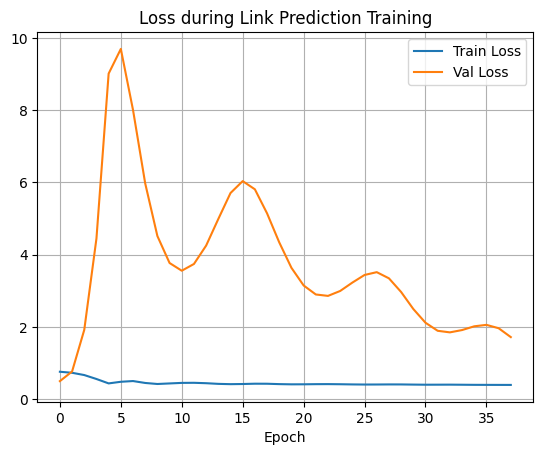

==================== Negative Sampling Ratio: 0.1 ====================
Epoch 000, Train Loss: 0.7361, Val Loss: 0.3777, Val AUC: 0.6495
Epoch 001, Train Loss: 0.6792, Val Loss: 0.8483, Val AUC: 0.6696
Epoch 002, Train Loss: 0.5207, Val Loss: 2.4533, Val AUC: 0.6708
Epoch 003, Train Loss: 0.3178, Val Loss: 5.8526, Val AUC: 0.6692
Epoch 004, Train Loss: 0.3320, Val Loss: 7.4117, Val AUC: 0.6690
Epoch 005, Train Loss: 0.3994, Val Loss: 6.6838, Val AUC: 0.6687
Epoch 006, Train Loss: 0.3516, Val Loss: 5.1780, Val AUC: 0.6691
Epoch 007, Train Loss: 0.2902, Val Loss: 3.8346, Val AUC: 0.6680
Epoch 008, Train Loss: 0.2804, Val Loss: 3.0207, Val AUC: 0.6659
Epoch 009, Train Loss: 0.3094, Val Loss: 2.7142, Val AUC: 0.6641
Epoch 010, Train Loss: 0.3226, Val Loss: 2.7709, Val AUC: 0.6631
Epoch 011, Train Loss: 0.3131, Val Loss: 3.1050, Val AUC: 0.6623
Epoch 012, Train Loss: 0.2904, Val Loss: 3.6448, Val AUC: 0.6622
Early stopping at epoch 12 (best AUC = 0.6708)
Loading the best model weights...


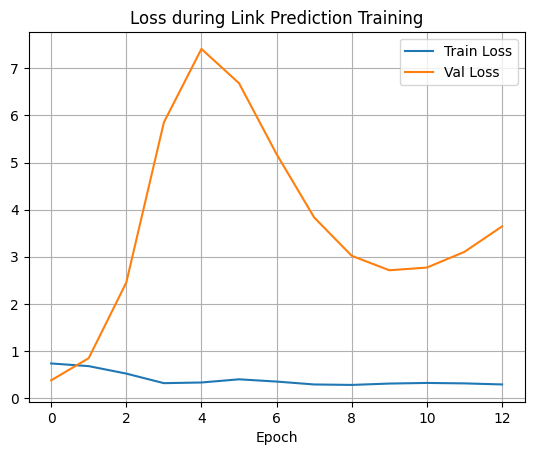

  Negative Sampling Ratio    Val Acc    Test Acc    Test AP
-------------------------  ---------  ----------  ---------
                      1     0.619309    0.656679   0.709108
                      0.5   0.67773     0.686373   0.834356
                      0.2   0.70122     0.664181   0.913928
                      0.1   0.662239    0.650661   0.952206


In [16]:
results = []

for negative_sampling_ratio in [1/1, 1/2, 1/5, 1/10]:
    print("=" * 20 + f" Negative Sampling Ratio: {negative_sampling_ratio} " + "=" * 20)

    transform = RandomLinkSplit(
        is_undirected=True,
        split_labels=True,
        add_negative_train_samples=True,
        neg_sampling_ratio=negative_sampling_ratio
    )
    train_data, val_data, test_data = transform(data)
    train_data, val_data = train_data.to(device), val_data.to(device)

    encoder = GCNEncoder(in_channels=dataset.num_features, out_channels=32).to(device)
    decoder = MLPDecoder(in_channels=32).to(device)
    val_acc, test_acc, test_ap = train_and_evaluate_link_model(encoder, decoder, train_data, val_data, test_data)
    results.append([negative_sampling_ratio, val_acc, test_acc, test_ap])

print(tabulate(results, headers=["Negative Sampling Ratio", "Val Acc", "Test Acc", "Test AP"]))

### 2.3 Оптизация текущей модели
Попробуйте улучшить текущую модель за счет использования следующих модификаций:
- добавление нормализации (BatchNorm / LayerNorm / PairNorm)
- Dropout
- residual connection

Опишите полученные результаты


==================== Norm: none, Dropout: 0.0, Skip: False ====================
Epoch 000, Train Loss: 0.7229, Val Loss: 0.4111, Val AUC: 0.4103
Epoch 001, Train Loss: 0.7059, Val Loss: 0.3558, Val AUC: 0.6333
Epoch 002, Train Loss: 0.6928, Val Loss: 0.4634, Val AUC: 0.6345
Epoch 003, Train Loss: 0.6767, Val Loss: 0.7884, Val AUC: 0.6639
Epoch 004, Train Loss: 0.6500, Val Loss: 1.4884, Val AUC: 0.6561
Epoch 005, Train Loss: 0.6025, Val Loss: 2.7918, Val AUC: 0.6602
Epoch 006, Train Loss: 0.5171, Val Loss: 5.0762, Val AUC: 0.6639
Epoch 007, Train Loss: 0.4030, Val Loss: 8.9391, Val AUC: 0.6649
Epoch 008, Train Loss: 0.3002, Val Loss: 14.7635, Val AUC: 0.6661
Epoch 009, Train Loss: 0.2964, Val Loss: 19.2625, Val AUC: 0.6662
Epoch 010, Train Loss: 0.3653, Val Loss: 19.7870, Val AUC: 0.6661
Epoch 011, Train Loss: 0.3822, Val Loss: 17.6103, Val AUC: 0.6647
Epoch 012, Train Loss: 0.3467, Val Loss: 14.3504, Val AUC: 0.6655
Epoch 013, Train Loss: 0.3030, Val Loss: 11.1474, Val AUC: 0.6658
Epoc

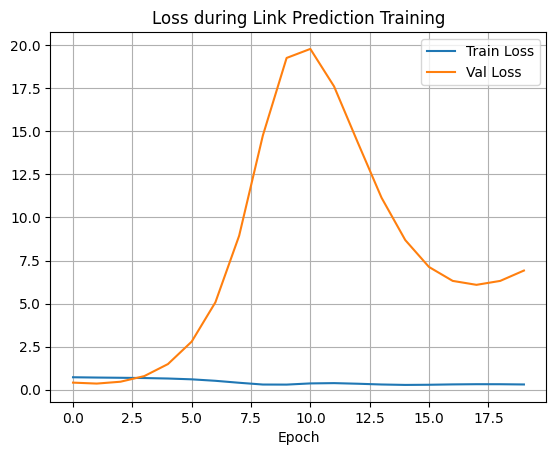

==================== Norm: none, Dropout: 0.0, Skip: True ====================
Epoch 000, Train Loss: 0.8165, Val Loss: 0.4555, Val AUC: 0.5884
Epoch 001, Train Loss: 0.7730, Val Loss: 0.3663, Val AUC: 0.6461
Epoch 002, Train Loss: 0.7351, Val Loss: 0.8482, Val AUC: 0.6635
Epoch 003, Train Loss: 0.6550, Val Loss: 1.9760, Val AUC: 0.6687
Epoch 004, Train Loss: 0.5147, Val Loss: 4.1022, Val AUC: 0.6687
Epoch 005, Train Loss: 0.3524, Val Loss: 7.9017, Val AUC: 0.6694
Epoch 006, Train Loss: 0.2842, Val Loss: 12.0831, Val AUC: 0.6692
Epoch 007, Train Loss: 0.3689, Val Loss: 13.2503, Val AUC: 0.6690
Epoch 008, Train Loss: 0.4073, Val Loss: 11.9889, Val AUC: 0.6680
Epoch 009, Train Loss: 0.3712, Val Loss: 9.7013, Val AUC: 0.6669
Epoch 010, Train Loss: 0.3174, Val Loss: 7.3769, Val AUC: 0.6667
Epoch 011, Train Loss: 0.2841, Val Loss: 5.5263, Val AUC: 0.6661
Epoch 012, Train Loss: 0.2838, Val Loss: 4.3485, Val AUC: 0.6656
Epoch 013, Train Loss: 0.3061, Val Loss: 3.7517, Val AUC: 0.6628
Epoch 01

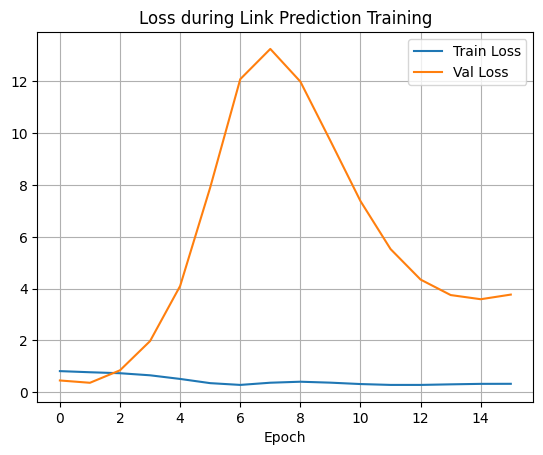

==================== Norm: none, Dropout: 0.5, Skip: False ====================
Epoch 000, Train Loss: 0.7622, Val Loss: 0.3376, Val AUC: 0.6617
Epoch 001, Train Loss: 0.7130, Val Loss: 0.8258, Val AUC: 0.6756
Epoch 002, Train Loss: 0.6034, Val Loss: 2.2888, Val AUC: 0.6749
Epoch 003, Train Loss: 0.4654, Val Loss: 5.3354, Val AUC: 0.6734
Epoch 004, Train Loss: 0.4054, Val Loss: 8.5700, Val AUC: 0.6724
Epoch 005, Train Loss: 0.4344, Val Loss: 8.9626, Val AUC: 0.6719
Epoch 006, Train Loss: 0.4545, Val Loss: 7.4450, Val AUC: 0.6704
Epoch 007, Train Loss: 0.3919, Val Loss: 5.5719, Val AUC: 0.6707
Epoch 008, Train Loss: 0.3731, Val Loss: 4.0321, Val AUC: 0.6711
Epoch 009, Train Loss: 0.3597, Val Loss: 3.0803, Val AUC: 0.6696
Epoch 010, Train Loss: 0.3767, Val Loss: 2.6219, Val AUC: 0.6670
Epoch 011, Train Loss: 0.3733, Val Loss: 2.5215, Val AUC: 0.6645
Early stopping at epoch 11 (best AUC = 0.6756)
Loading the best model weights...


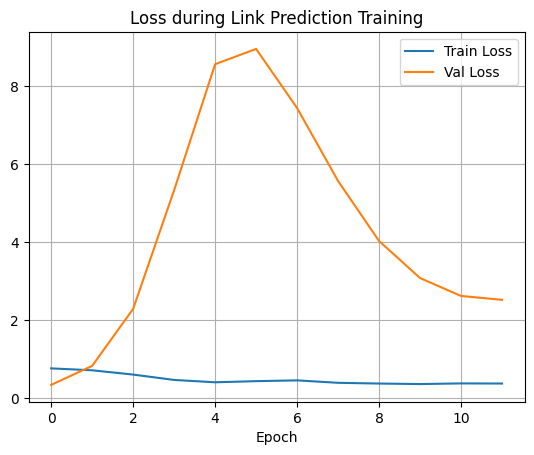

==================== Norm: none, Dropout: 0.5, Skip: True ====================
Epoch 000, Train Loss: 0.6829, Val Loss: 0.3772, Val AUC: 0.6276
Epoch 001, Train Loss: 0.6490, Val Loss: 0.6043, Val AUC: 0.6467
Epoch 002, Train Loss: 0.5878, Val Loss: 1.6447, Val AUC: 0.6548
Epoch 003, Train Loss: 0.4858, Val Loss: 3.8318, Val AUC: 0.6595
Epoch 004, Train Loss: 0.3853, Val Loss: 7.4696, Val AUC: 0.6622
Epoch 005, Train Loss: 0.3722, Val Loss: 9.6692, Val AUC: 0.6633
Epoch 006, Train Loss: 0.4198, Val Loss: 9.1964, Val AUC: 0.6625
Epoch 007, Train Loss: 0.4204, Val Loss: 7.4456, Val AUC: 0.6620
Epoch 008, Train Loss: 0.3728, Val Loss: 5.5843, Val AUC: 0.6600
Epoch 009, Train Loss: 0.3568, Val Loss: 4.1606, Val AUC: 0.6569
Epoch 010, Train Loss: 0.3489, Val Loss: 3.3184, Val AUC: 0.6531
Epoch 011, Train Loss: 0.3653, Val Loss: 2.9007, Val AUC: 0.6511
Epoch 012, Train Loss: 0.3651, Val Loss: 2.7908, Val AUC: 0.6503
Epoch 013, Train Loss: 0.3454, Val Loss: 2.9093, Val AUC: 0.6506
Epoch 014, 

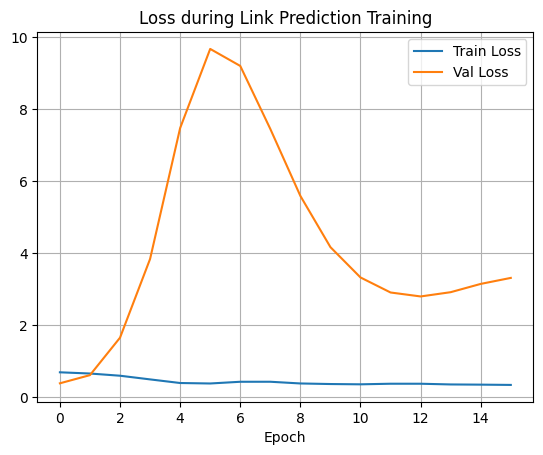

==================== Norm: batch, Dropout: 0.0, Skip: False ====================
Epoch 000, Train Loss: 0.7240, Val Loss: 0.4758, Val AUC: 0.5081
Epoch 001, Train Loss: 0.6763, Val Loss: 0.3842, Val AUC: 0.5370
Epoch 002, Train Loss: 0.6405, Val Loss: 0.3519, Val AUC: 0.5411
Epoch 003, Train Loss: 0.6262, Val Loss: 0.3710, Val AUC: 0.5699
Epoch 004, Train Loss: 0.6136, Val Loss: 0.4158, Val AUC: 0.5830
Epoch 005, Train Loss: 0.6029, Val Loss: 0.4713, Val AUC: 0.5821
Epoch 006, Train Loss: 0.5926, Val Loss: 0.5289, Val AUC: 0.5804
Epoch 007, Train Loss: 0.5818, Val Loss: 0.5861, Val AUC: 0.5708
Epoch 008, Train Loss: 0.5709, Val Loss: 0.6413, Val AUC: 0.5659
Epoch 009, Train Loss: 0.5597, Val Loss: 0.6928, Val AUC: 0.5578
Epoch 010, Train Loss: 0.5480, Val Loss: 0.7421, Val AUC: 0.5527
Epoch 011, Train Loss: 0.5361, Val Loss: 0.7965, Val AUC: 0.5353
Epoch 012, Train Loss: 0.5237, Val Loss: 0.8395, Val AUC: 0.5058
Epoch 013, Train Loss: 0.5105, Val Loss: 0.8663, Val AUC: 0.4696
Epoch 014

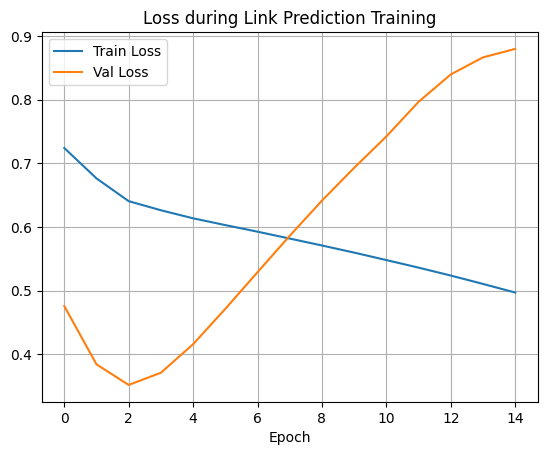

==================== Norm: batch, Dropout: 0.0, Skip: True ====================
Epoch 000, Train Loss: 0.8154, Val Loss: 0.4834, Val AUC: 0.5416
Epoch 001, Train Loss: 0.7861, Val Loss: 0.4196, Val AUC: 0.4435
Epoch 002, Train Loss: 0.7623, Val Loss: 0.3610, Val AUC: 0.4388
Epoch 003, Train Loss: 0.7474, Val Loss: 0.3240, Val AUC: 0.4499
Epoch 004, Train Loss: 0.7335, Val Loss: 0.3090, Val AUC: 0.4429
Epoch 005, Train Loss: 0.7201, Val Loss: 0.3079, Val AUC: 0.4448
Epoch 006, Train Loss: 0.7065, Val Loss: 0.3147, Val AUC: 0.4338
Epoch 007, Train Loss: 0.6922, Val Loss: 0.3252, Val AUC: 0.4294
Epoch 008, Train Loss: 0.6772, Val Loss: 0.3363, Val AUC: 0.4297
Epoch 009, Train Loss: 0.6613, Val Loss: 0.3453, Val AUC: 0.4450
Epoch 010, Train Loss: 0.6446, Val Loss: 0.3511, Val AUC: 0.4659
Early stopping at epoch 10 (best AUC = 0.5416)
Loading the best model weights...


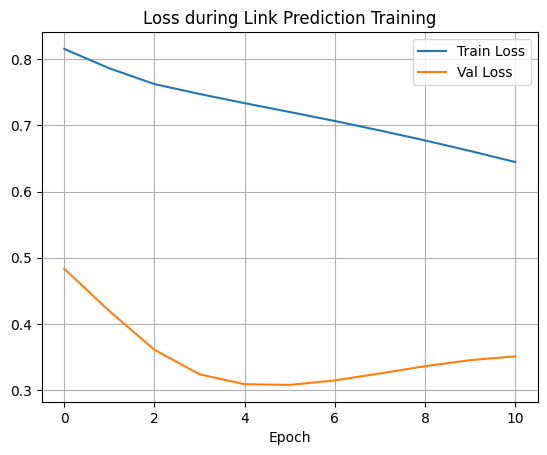

==================== Norm: batch, Dropout: 0.5, Skip: False ====================
Epoch 000, Train Loss: 0.8200, Val Loss: 0.5570, Val AUC: 0.4400
Epoch 001, Train Loss: 0.7792, Val Loss: 0.4921, Val AUC: 0.4816
Epoch 002, Train Loss: 0.7464, Val Loss: 0.4155, Val AUC: 0.4508
Epoch 003, Train Loss: 0.7392, Val Loss: 0.3641, Val AUC: 0.4353
Epoch 004, Train Loss: 0.7207, Val Loss: 0.3530, Val AUC: 0.4623
Epoch 005, Train Loss: 0.7069, Val Loss: 0.3739, Val AUC: 0.4972
Epoch 006, Train Loss: 0.6934, Val Loss: 0.4146, Val AUC: 0.5137
Epoch 007, Train Loss: 0.6878, Val Loss: 0.4757, Val AUC: 0.5391
Epoch 008, Train Loss: 0.6741, Val Loss: 0.5411, Val AUC: 0.5797
Epoch 009, Train Loss: 0.6694, Val Loss: 0.6101, Val AUC: 0.5971
Epoch 010, Train Loss: 0.6571, Val Loss: 0.6940, Val AUC: 0.5987
Epoch 011, Train Loss: 0.6500, Val Loss: 0.7750, Val AUC: 0.5929
Epoch 012, Train Loss: 0.6451, Val Loss: 0.8471, Val AUC: 0.5624
Epoch 013, Train Loss: 0.6250, Val Loss: 0.9102, Val AUC: 0.5403
Epoch 014

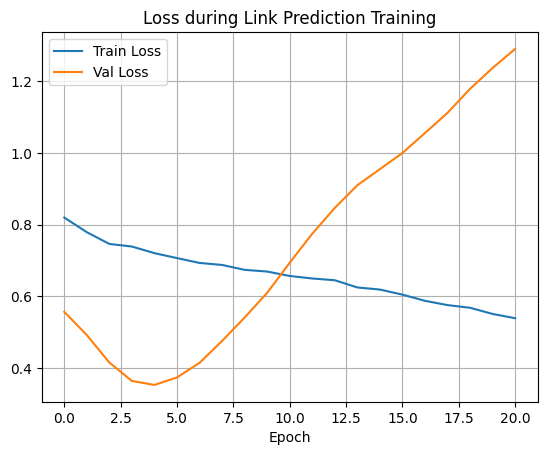

==================== Norm: batch, Dropout: 0.5, Skip: True ====================
Epoch 000, Train Loss: 0.7212, Val Loss: 0.5749, Val AUC: 0.5581
Epoch 001, Train Loss: 0.6757, Val Loss: 0.4558, Val AUC: 0.5999
Epoch 002, Train Loss: 0.6602, Val Loss: 0.3692, Val AUC: 0.4827
Epoch 003, Train Loss: 0.6357, Val Loss: 0.3360, Val AUC: 0.4555
Epoch 004, Train Loss: 0.6254, Val Loss: 0.3407, Val AUC: 0.4537
Epoch 005, Train Loss: 0.6130, Val Loss: 0.3676, Val AUC: 0.4501
Epoch 006, Train Loss: 0.6058, Val Loss: 0.4121, Val AUC: 0.4334
Epoch 007, Train Loss: 0.5947, Val Loss: 0.4677, Val AUC: 0.4027
Epoch 008, Train Loss: 0.5854, Val Loss: 0.5297, Val AUC: 0.4022
Epoch 009, Train Loss: 0.5785, Val Loss: 0.5982, Val AUC: 0.4037
Epoch 010, Train Loss: 0.5784, Val Loss: 0.6665, Val AUC: 0.4002
Epoch 011, Train Loss: 0.5693, Val Loss: 0.7377, Val AUC: 0.4046
Early stopping at epoch 11 (best AUC = 0.5999)
Loading the best model weights...


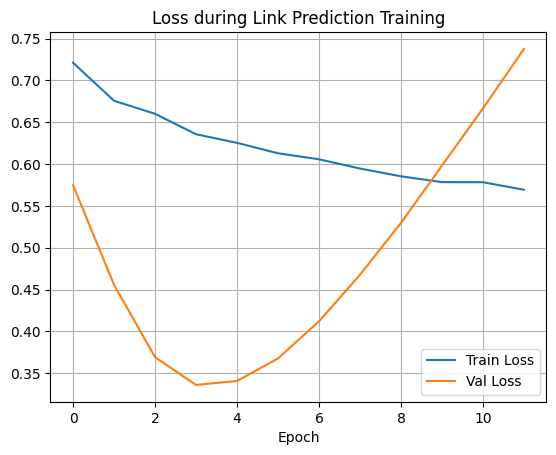

==================== Norm: layer, Dropout: 0.0, Skip: False ====================
Epoch 000, Train Loss: 0.4520, Val Loss: 0.3688, Val AUC: 0.4566
Epoch 001, Train Loss: 0.3442, Val Loss: 0.4252, Val AUC: 0.5128
Epoch 002, Train Loss: 0.3033, Val Loss: 0.6950, Val AUC: 0.4999
Epoch 003, Train Loss: 0.3034, Val Loss: 1.0417, Val AUC: 0.4828
Epoch 004, Train Loss: 0.3042, Val Loss: 1.4208, Val AUC: 0.5077
Epoch 005, Train Loss: 0.3047, Val Loss: 1.8138, Val AUC: 0.5233
Epoch 006, Train Loss: 0.3052, Val Loss: 2.2078, Val AUC: 0.5097
Epoch 007, Train Loss: 0.3051, Val Loss: 2.5927, Val AUC: 0.4893
Epoch 008, Train Loss: 0.3049, Val Loss: 2.9613, Val AUC: 0.4763
Epoch 009, Train Loss: 0.3040, Val Loss: 3.3062, Val AUC: 0.4984
Epoch 010, Train Loss: 0.3040, Val Loss: 3.6185, Val AUC: 0.5402
Epoch 011, Train Loss: 0.3044, Val Loss: 3.8930, Val AUC: 0.5586
Epoch 012, Train Loss: 0.3041, Val Loss: 4.1300, Val AUC: 0.5673
Epoch 013, Train Loss: 0.3042, Val Loss: 4.3320, Val AUC: 0.5626
Epoch 014

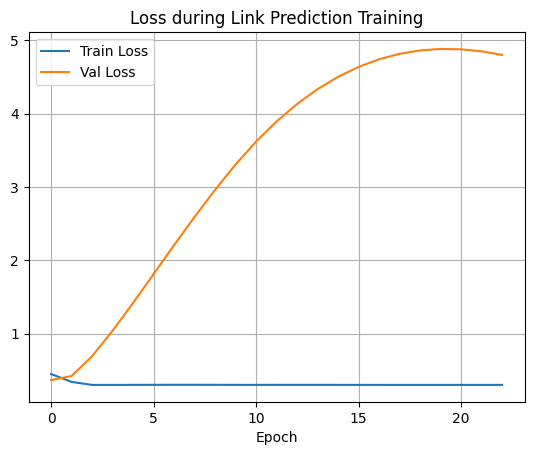

==================== Norm: layer, Dropout: 0.0, Skip: True ====================
Epoch 000, Train Loss: 0.5600, Val Loss: 0.3574, Val AUC: 0.4287
Epoch 001, Train Loss: 0.3822, Val Loss: 0.5278, Val AUC: 0.4464
Epoch 002, Train Loss: 0.3132, Val Loss: 1.0082, Val AUC: 0.4226
Epoch 003, Train Loss: 0.3048, Val Loss: 1.6161, Val AUC: 0.4958
Epoch 004, Train Loss: 0.3046, Val Loss: 2.3028, Val AUC: 0.5128
Epoch 005, Train Loss: 0.3043, Val Loss: 3.0374, Val AUC: 0.5176
Epoch 006, Train Loss: 0.3046, Val Loss: 3.7969, Val AUC: 0.5195
Epoch 007, Train Loss: 0.3042, Val Loss: 4.5597, Val AUC: 0.5197
Epoch 008, Train Loss: 0.3041, Val Loss: 5.3097, Val AUC: 0.5197
Epoch 009, Train Loss: 0.3042, Val Loss: 6.0339, Val AUC: 0.5212
Epoch 010, Train Loss: 0.3045, Val Loss: 6.7215, Val AUC: 0.5250
Epoch 011, Train Loss: 0.3044, Val Loss: 7.3628, Val AUC: 0.5265
Epoch 012, Train Loss: 0.3043, Val Loss: 7.9531, Val AUC: 0.5265
Epoch 013, Train Loss: 0.3042, Val Loss: 8.4860, Val AUC: 0.5267
Epoch 014,

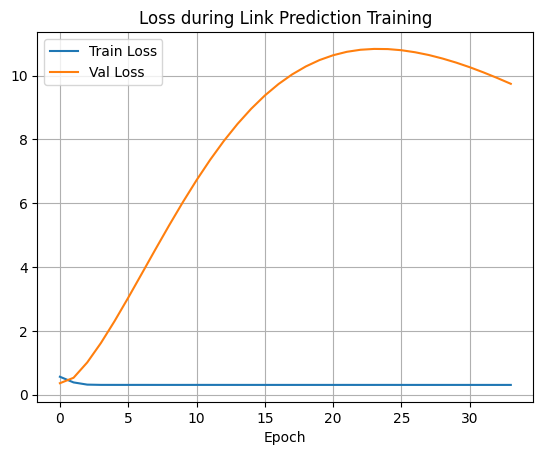

==================== Norm: layer, Dropout: 0.5, Skip: False ====================
Epoch 000, Train Loss: 0.6037, Val Loss: 0.3902, Val AUC: 0.4698
Epoch 001, Train Loss: 0.3730, Val Loss: 0.4159, Val AUC: 0.5866
Epoch 002, Train Loss: 0.3352, Val Loss: 0.7104, Val AUC: 0.5777
Epoch 003, Train Loss: 0.3349, Val Loss: 1.1195, Val AUC: 0.5648
Epoch 004, Train Loss: 0.3233, Val Loss: 1.5819, Val AUC: 0.5488
Epoch 005, Train Loss: 0.3181, Val Loss: 2.0672, Val AUC: 0.5631
Epoch 006, Train Loss: 0.3189, Val Loss: 2.5553, Val AUC: 0.5504
Epoch 007, Train Loss: 0.3218, Val Loss: 3.0330, Val AUC: 0.5633
Epoch 008, Train Loss: 0.3257, Val Loss: 3.4905, Val AUC: 0.5858
Epoch 009, Train Loss: 0.3200, Val Loss: 3.9174, Val AUC: 0.5998
Epoch 010, Train Loss: 0.3181, Val Loss: 4.3082, Val AUC: 0.5957
Epoch 011, Train Loss: 0.3229, Val Loss: 4.6582, Val AUC: 0.5799
Epoch 012, Train Loss: 0.3195, Val Loss: 4.9650, Val AUC: 0.5605
Epoch 013, Train Loss: 0.3186, Val Loss: 5.2284, Val AUC: 0.5484
Epoch 014

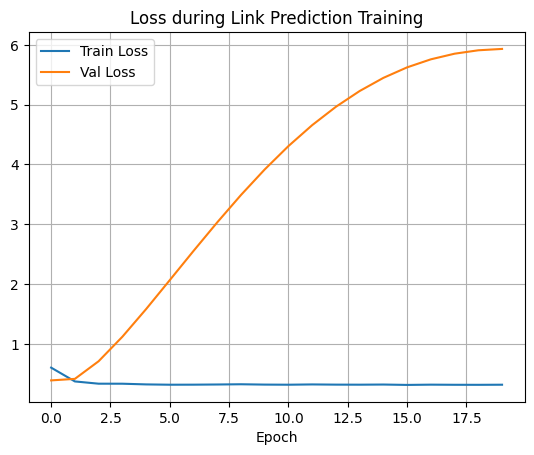

==================== Norm: layer, Dropout: 0.5, Skip: True ====================
Epoch 000, Train Loss: 1.0823, Val Loss: 0.3319, Val AUC: 0.5042
Epoch 001, Train Loss: 0.4742, Val Loss: 0.7047, Val AUC: 0.5082
Epoch 002, Train Loss: 0.4123, Val Loss: 1.3580, Val AUC: 0.4380
Epoch 003, Train Loss: 0.3930, Val Loss: 2.1419, Val AUC: 0.4415
Epoch 004, Train Loss: 0.3733, Val Loss: 3.0046, Val AUC: 0.4565
Epoch 005, Train Loss: 0.3630, Val Loss: 3.9109, Val AUC: 0.4813
Epoch 006, Train Loss: 0.3623, Val Loss: 4.8379, Val AUC: 0.4899
Epoch 007, Train Loss: 0.3472, Val Loss: 5.7639, Val AUC: 0.4928
Epoch 008, Train Loss: 0.3401, Val Loss: 6.6713, Val AUC: 0.4875
Epoch 009, Train Loss: 0.3319, Val Loss: 7.5470, Val AUC: 0.4866
Epoch 010, Train Loss: 0.3313, Val Loss: 8.3801, Val AUC: 0.4846
Epoch 011, Train Loss: 0.3292, Val Loss: 9.1607, Val AUC: 0.4848
Early stopping at epoch 11 (best AUC = 0.5082)
Loading the best model weights...


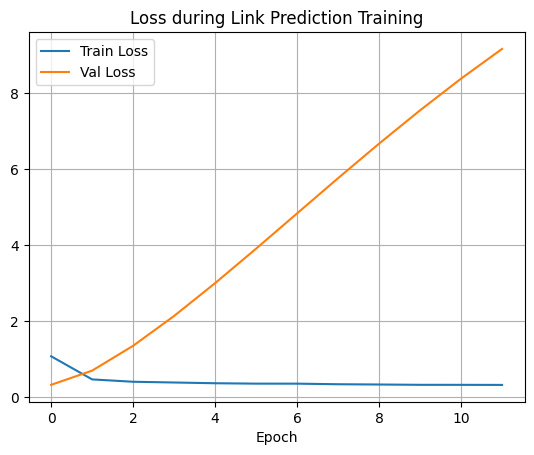

==================== Norm: pair, Dropout: 0.0, Skip: False ====================
Epoch 000, Train Loss: 0.6264, Val Loss: 0.4925, Val AUC: 0.5191
Epoch 001, Train Loss: 0.6216, Val Loss: 0.3957, Val AUC: 0.4865
Epoch 002, Train Loss: 0.6177, Val Loss: 0.3647, Val AUC: 0.4717
Epoch 003, Train Loss: 0.6140, Val Loss: 0.3568, Val AUC: 0.4718
Epoch 004, Train Loss: 0.6104, Val Loss: 0.3585, Val AUC: 0.4897
Epoch 005, Train Loss: 0.6069, Val Loss: 0.3665, Val AUC: 0.4918
Epoch 006, Train Loss: 0.6034, Val Loss: 0.3814, Val AUC: 0.4902
Epoch 007, Train Loss: 0.5999, Val Loss: 0.4035, Val AUC: 0.4915
Epoch 008, Train Loss: 0.5964, Val Loss: 0.4321, Val AUC: 0.4996
Epoch 009, Train Loss: 0.5930, Val Loss: 0.4652, Val AUC: 0.5015
Epoch 010, Train Loss: 0.5896, Val Loss: 0.5001, Val AUC: 0.5001
Early stopping at epoch 10 (best AUC = 0.5191)
Loading the best model weights...


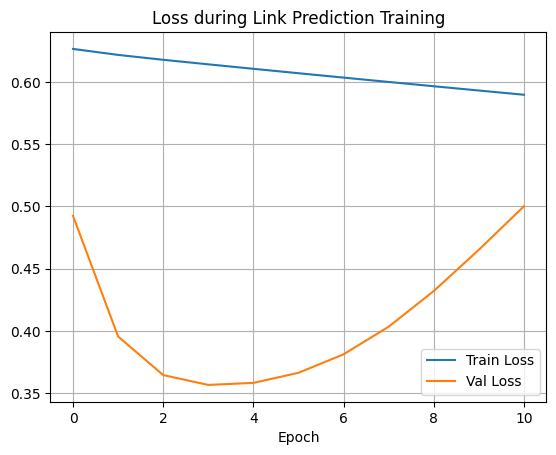

==================== Norm: pair, Dropout: 0.0, Skip: True ====================
Epoch 000, Train Loss: 0.6031, Val Loss: 0.4995, Val AUC: 0.4547
Epoch 001, Train Loss: 0.5979, Val Loss: 0.3954, Val AUC: 0.4860
Epoch 002, Train Loss: 0.5933, Val Loss: 0.3591, Val AUC: 0.5307
Epoch 003, Train Loss: 0.5896, Val Loss: 0.3535, Val AUC: 0.5406
Epoch 004, Train Loss: 0.5861, Val Loss: 0.3556, Val AUC: 0.5279
Epoch 005, Train Loss: 0.5826, Val Loss: 0.3571, Val AUC: 0.4835
Epoch 006, Train Loss: 0.5793, Val Loss: 0.3568, Val AUC: 0.4958
Epoch 007, Train Loss: 0.5760, Val Loss: 0.3557, Val AUC: 0.5127
Epoch 008, Train Loss: 0.5727, Val Loss: 0.3558, Val AUC: 0.5349
Epoch 009, Train Loss: 0.5694, Val Loss: 0.3587, Val AUC: 0.5285
Epoch 010, Train Loss: 0.5662, Val Loss: 0.3656, Val AUC: 0.5130
Epoch 011, Train Loss: 0.5630, Val Loss: 0.3773, Val AUC: 0.5082
Epoch 012, Train Loss: 0.5598, Val Loss: 0.3933, Val AUC: 0.5072
Epoch 013, Train Loss: 0.5567, Val Loss: 0.4131, Val AUC: 0.5031
Early stopp

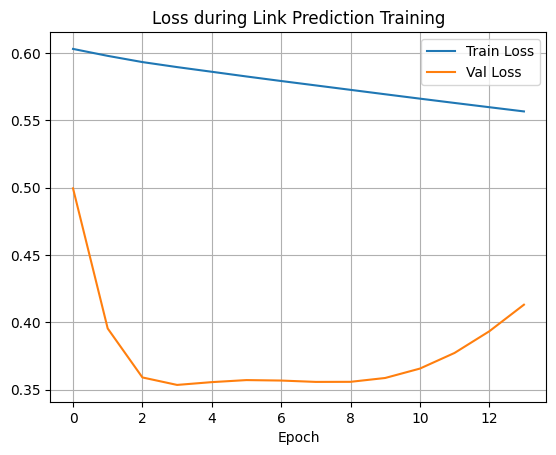

==================== Norm: pair, Dropout: 0.5, Skip: False ====================
Epoch 000, Train Loss: 0.6642, Val Loss: 0.5919, Val AUC: 0.5116
Epoch 001, Train Loss: 0.6594, Val Loss: 0.4803, Val AUC: 0.4834
Epoch 002, Train Loss: 0.6536, Val Loss: 0.4039, Val AUC: 0.4881
Epoch 003, Train Loss: 0.6490, Val Loss: 0.3552, Val AUC: 0.4933
Epoch 004, Train Loss: 0.6443, Val Loss: 0.3290, Val AUC: 0.5058
Epoch 005, Train Loss: 0.6412, Val Loss: 0.3219, Val AUC: 0.5206
Epoch 006, Train Loss: 0.6369, Val Loss: 0.3250, Val AUC: 0.5332
Epoch 007, Train Loss: 0.6332, Val Loss: 0.3347, Val AUC: 0.5344
Epoch 008, Train Loss: 0.6302, Val Loss: 0.3482, Val AUC: 0.5099
Epoch 009, Train Loss: 0.6251, Val Loss: 0.3598, Val AUC: 0.5022
Epoch 010, Train Loss: 0.6220, Val Loss: 0.3688, Val AUC: 0.5087
Epoch 011, Train Loss: 0.6186, Val Loss: 0.3732, Val AUC: 0.5199
Epoch 012, Train Loss: 0.6155, Val Loss: 0.3737, Val AUC: 0.5237
Epoch 013, Train Loss: 0.6119, Val Loss: 0.3708, Val AUC: 0.5292
Epoch 014,

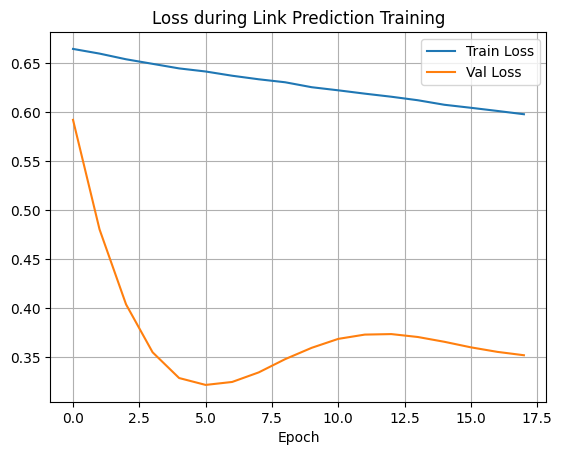

==================== Norm: pair, Dropout: 0.5, Skip: True ====================
Epoch 000, Train Loss: 0.7183, Val Loss: 0.5594, Val AUC: 0.4854
Epoch 001, Train Loss: 0.7106, Val Loss: 0.4734, Val AUC: 0.5018
Epoch 002, Train Loss: 0.7039, Val Loss: 0.4257, Val AUC: 0.5180
Epoch 003, Train Loss: 0.6987, Val Loss: 0.3877, Val AUC: 0.4992
Epoch 004, Train Loss: 0.6938, Val Loss: 0.3652, Val AUC: 0.4925
Epoch 005, Train Loss: 0.6925, Val Loss: 0.3496, Val AUC: 0.4989
Epoch 006, Train Loss: 0.6860, Val Loss: 0.3427, Val AUC: 0.5133
Epoch 007, Train Loss: 0.6823, Val Loss: 0.3445, Val AUC: 0.5324
Epoch 008, Train Loss: 0.6780, Val Loss: 0.3542, Val AUC: 0.5161
Epoch 009, Train Loss: 0.6740, Val Loss: 0.3696, Val AUC: 0.4894
Epoch 010, Train Loss: 0.6699, Val Loss: 0.3833, Val AUC: 0.4905
Epoch 011, Train Loss: 0.6658, Val Loss: 0.3971, Val AUC: 0.4845
Epoch 012, Train Loss: 0.6622, Val Loss: 0.4119, Val AUC: 0.4831
Epoch 013, Train Loss: 0.6577, Val Loss: 0.4211, Val AUC: 0.4824
Epoch 014, 

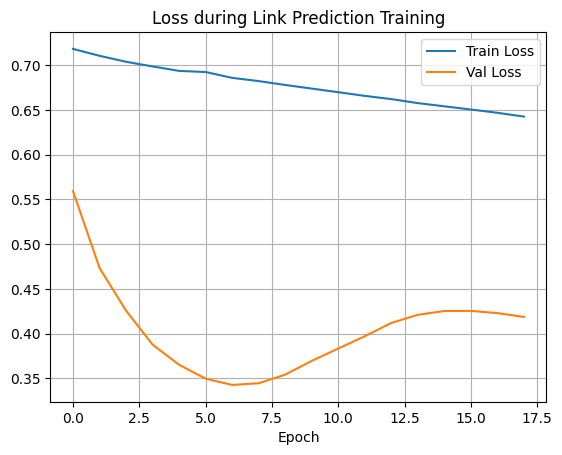

Normalization      Dropout  Skip Connections      Val Acc    Test Acc    Test AP
---------------  ---------  ------------------  ---------  ----------  ---------
none                   0    False                0.662859    0.651207   0.952571
none                   0    True                 0.660561    0.65067    0.952436
none                   0.5  False                0.664538    0.638718   0.950688
none                   0.5  True                 0.650489    0.648576   0.952142
batch                  0    False                0.448146    0.508228   0.914385
batch                  0    True                 0.465881    0.453672   0.906556
batch                  0.5  False                0.491899    0.463986   0.907513
batch                  0.5  True                 0.404576    0.494976   0.924157
layer                  0    False                0.551325    0.524617   0.920698
layer                  0    True                 0.537403    0.544771   0.925911
layer                  0.5  

In [17]:
results = []

for normalization in ['none', 'batch', 'layer', 'pair']:
    for dropout in [0.0, 0.5]:
        for skip_connections in [False, True]:
            print("=" * 20 + f" Norm: {normalization}, Dropout: {dropout}, Skip: {skip_connections} " + "=" * 20)
            encoder = GCNEncoder(in_channels=dataset.num_features, out_channels=32).to(device)
            decoder = MLPDecoder(
                in_channels=32,
                normalization=normalization,
                dropout=dropout,
                use_skip_connections=skip_connections,
            ).to(device)
            val_acc, test_acc, test_ap = train_and_evaluate_link_model(encoder, decoder, train_data, val_data, test_data)
            results.append([normalization, dropout, skip_connections, val_acc, test_acc, test_ap])

print(tabulate(results, headers=["Normalization", "Dropout", "Skip Connections", "Val Acc", "Test Acc", "Test AP"]))

### 2.4 Реализация и сравнение GCN / GraphSAGE / GAT / GIN
Выберите 2 базовые архитектуры из списка: GraphSAGE, GAT(v2), GIN. Реализуйте их для задачи node classification и сравните полученные результаты.

Комментарий: при реализации, можно использовать наработки с предыдущих пунктов - добавлять разные виды модификаций (увеличивать число слоев / добавлять слои нормализации / residual conections...)


==================== Architecture: gcn ====================
Epoch 000, Train Loss: 0.6242, Val Loss: 0.6114, Val AUC: 0.5034
Epoch 001, Train Loss: 0.6169, Val Loss: 0.5336, Val AUC: 0.4869
Epoch 002, Train Loss: 0.6135, Val Loss: 0.4647, Val AUC: 0.4941
Epoch 003, Train Loss: 0.6089, Val Loss: 0.4149, Val AUC: 0.4825
Epoch 004, Train Loss: 0.6038, Val Loss: 0.3757, Val AUC: 0.4877
Epoch 005, Train Loss: 0.6010, Val Loss: 0.3522, Val AUC: 0.4955
Epoch 006, Train Loss: 0.5966, Val Loss: 0.3391, Val AUC: 0.5080
Epoch 007, Train Loss: 0.5933, Val Loss: 0.3330, Val AUC: 0.5133
Epoch 008, Train Loss: 0.5894, Val Loss: 0.3319, Val AUC: 0.5170
Epoch 009, Train Loss: 0.5865, Val Loss: 0.3336, Val AUC: 0.5175
Epoch 010, Train Loss: 0.5835, Val Loss: 0.3363, Val AUC: 0.5086
Epoch 011, Train Loss: 0.5799, Val Loss: 0.3386, Val AUC: 0.4952
Epoch 012, Train Loss: 0.5762, Val Loss: 0.3405, Val AUC: 0.4869
Epoch 013, Train Loss: 0.5729, Val Loss: 0.3420, Val AUC: 0.4844
Epoch 014, Train Loss: 0.5696,

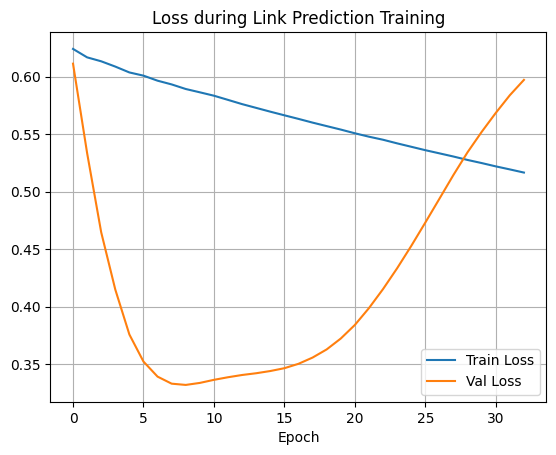

==================== Architecture: sage ====================
Epoch 000, Train Loss: 0.6663, Val Loss: 0.5710, Val AUC: 0.4829
Epoch 001, Train Loss: 0.6592, Val Loss: 0.4874, Val AUC: 0.4907
Epoch 002, Train Loss: 0.6531, Val Loss: 0.3914, Val AUC: 0.5042
Epoch 003, Train Loss: 0.6467, Val Loss: 0.3397, Val AUC: 0.5045
Epoch 004, Train Loss: 0.6432, Val Loss: 0.3320, Val AUC: 0.5011
Epoch 005, Train Loss: 0.6392, Val Loss: 0.3579, Val AUC: 0.5030
Epoch 006, Train Loss: 0.6352, Val Loss: 0.4036, Val AUC: 0.5010
Epoch 007, Train Loss: 0.6318, Val Loss: 0.4530, Val AUC: 0.5009
Epoch 008, Train Loss: 0.6266, Val Loss: 0.5012, Val AUC: 0.5032
Epoch 009, Train Loss: 0.6243, Val Loss: 0.5483, Val AUC: 0.5082
Epoch 010, Train Loss: 0.6204, Val Loss: 0.5883, Val AUC: 0.5124
Epoch 011, Train Loss: 0.6162, Val Loss: 0.6253, Val AUC: 0.5138
Epoch 012, Train Loss: 0.6123, Val Loss: 0.6477, Val AUC: 0.5170
Epoch 013, Train Loss: 0.6094, Val Loss: 0.6646, Val AUC: 0.5164
Epoch 014, Train Loss: 0.6061

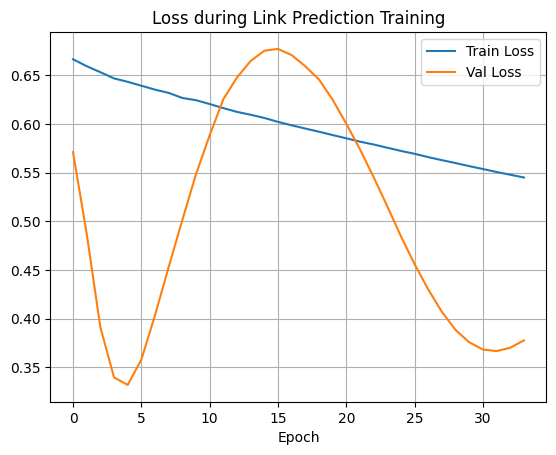

==================== Architecture: gatv2 ====================
Epoch 000, Train Loss: 0.7238, Val Loss: 0.6629, Val AUC: 0.5055
Epoch 001, Train Loss: 0.7174, Val Loss: 0.6426, Val AUC: 0.5186
Epoch 002, Train Loss: 0.7100, Val Loss: 0.6164, Val AUC: 0.5184
Epoch 003, Train Loss: 0.7065, Val Loss: 0.5904, Val AUC: 0.4946
Epoch 004, Train Loss: 0.7022, Val Loss: 0.5590, Val AUC: 0.5000
Epoch 005, Train Loss: 0.6970, Val Loss: 0.5294, Val AUC: 0.5053
Epoch 006, Train Loss: 0.6914, Val Loss: 0.5034, Val AUC: 0.4925
Epoch 007, Train Loss: 0.6881, Val Loss: 0.4827, Val AUC: 0.4915
Epoch 008, Train Loss: 0.6828, Val Loss: 0.4672, Val AUC: 0.4932
Epoch 009, Train Loss: 0.6797, Val Loss: 0.4562, Val AUC: 0.4948
Epoch 010, Train Loss: 0.6765, Val Loss: 0.4489, Val AUC: 0.5022
Epoch 011, Train Loss: 0.6715, Val Loss: 0.4452, Val AUC: 0.4970
Early stopping at epoch 11 (best AUC = 0.5186)
Loading the best model weights...


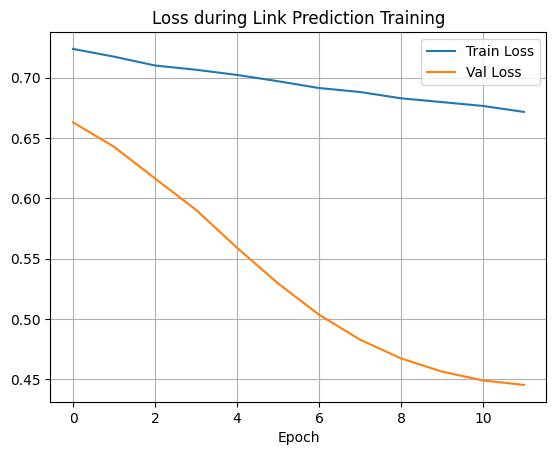

Architecture      Dropout  Skip Connections      Val Acc    Test Acc    Test AP
--------------  ---------  ------------------  ---------  ----------  ---------
pair                  0.5  True                 0.497263    0.471997   0.870578
pair                  0.5  True                 0.486973    0.500181   0.907614
pair                  0.5  True                 0.497044    0.51434    0.908622


In [18]:
results = []

for architecture in ['gcn', 'sage', 'gatv2']:
    print("=" * 20 + f" Architecture: {architecture} " + "=" * 20)
    encoder = GCNEncoder(in_channels=dataset.num_features, out_channels=32, conv_type=architecture, gatv2_heads=4).to(device)
    decoder = MLPDecoder(
        in_channels=32,
        normalization=normalization,
        dropout=dropout,
        use_skip_connections=skip_connections,
    ).to(device)
    val_acc, test_acc, test_ap = train_and_evaluate_link_model(encoder, decoder, train_data, val_data, test_data)
    results.append([normalization, dropout, skip_connections, val_acc, test_acc, test_ap])

print(tabulate(results, headers=["Architecture", "Dropout", "Skip Connections", "Val Acc", "Test Acc", "Test AP"]))